<a href="https://colab.research.google.com/github/Roman-212/Digital-breakthrough-2022-Accident-prediction---Dagestan/blob/main/%22%D0%94%D0%B0%D0%B3%D0%B5%D1%81%D1%82%D0%B0%D0%BD_%D0%94%D0%A2%D0%9F%22_%E2%84%967_%D1%84%D0%B8%D0%BD%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9_%D0%B2%D0%B0%D1%80%D0%B8%D0%B0%D0%BD%D1%82%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np #Библиотека работы с массивами
import pandas as pd # Библиотека для работы с базами
import time # Импортируем библиотеку time
from datetime import datetime

from tensorflow.keras.models import Sequential, Model # 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten #
from tensorflow.keras import utils #Используем для to_categoricall
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop #
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence #
from tensorflow.keras.preprocessing.sequence import pad_sequences #
from tensorflow.keras.callbacks import LambdaCallback # подключаем колбэки
from tensorflow.keras.callbacks import ModelCheckpoint # Для колбека

from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов
from sklearn.preprocessing import StandardScaler # 
from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.metrics import mean_squared_error, mean_absolute_error #
#from google.colab import files #Для загрузки своей картинки

import random #Для генерации случайных чисел 
import math # Для округления
#import os #Для работы с файлами 
import re #
import matplotlib.pyplot as plt #
%matplotlib inline

from IPython.display import clear_output

In [2]:
from google.colab import drive # Подключаем диск
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Предобученные сети/Дагенстан_ДТП/train_dataset_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Предобученные сети/Дагенстан_ДТП/test_dataset_test.csv')

In [4]:
df['Вид ДТП'].fillna(value='Не известно', inplace=True) # Заменим пропуски на 'Иной вид ДТП'

In [5]:
df.drop(df.columns[[0,4,5,6,7,8]], axis=1, inplace=True) # Удаляем лишнии столбцы

In [6]:
df

,Дата,Время,Место,Вид ДТП,Погибло,Погибло детей,Ранено,Ранено детей
0,13.07.2018,17:35:00,"Новгородская область, Великий Новгород",Столкновение,0,0,0,0
1,11.05.2018,17:10:00,"Новгородская область, Великий Новгород",Столкновение,0,0,0,0
2,25.01.2020,14:44:00,"Новгородская область, Великий Новгород",Не известно,0,0,0,0
3,11.05.2020,11:30:00,"Новгородская область, Новгородский район, Сави...",Не известно,0,0,0,0
4,09.01.2019,01:45:00,"Новгородская область, Окуловский район",Иной вид ДТП,0,0,0,0
...,...,...,...,...,...,...,...,...
35766,15.05.2019,07:35:00,"Новгородская область, Великий Новгород",Столкновение,0,0,0,0
35767,15.10.2019,08:45:00,"Новгородская область, Великий Новгород",Столкновение,0,0,0,0
35768,10.03.2019,09:00:00,"Новгородская область, Старорусский район, Стар...",Наезд на стоящее ТС,0,0,0,0
35769,13.09.2020,05:40:00,"Новгородская область, Новгородский район",Не известно,0,0,0,0


In [7]:
# Объдиняем место, вид ДТП и временые интервалы
df["Место"] = df["Дата"].astype(str) +  " " + df["Время"].astype(str) + " " + df["Место"].astype(str) + " " + df["Вид ДТП"].astype(str) 

# **Модель для предсказания "Погибло"**

In [8]:
texts = df['Место'].values # Извлекаем данные всех текстов из столбца 'Место'
classes = list(df['Погибло'].values) # Извлекаем соответствующие им значения классов (лейблов) столбца 'Текст Сообщения'
maxWordsCount = 1000 # Зададим максимальное количество слов/индексов, учитываемое при обучении текстов

print(df['Погибло'].unique()) # Выводим все уникальные значения классов
nClasses = df['Погибло'].nunique() # Задаём количество классов, обращаясь к столбцу 'Категория' и оставляя уникальные значения
print('Количество классов =', nClasses) # Посмотрим на количество классов

[0 1 2 3]
Количество классов = 4


In [9]:
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='unknown', char_level=False)#False
tokenizer.fit_on_texts(texts) # Даём в обработку наши тексты, методу, который соберет словарь частотности
# Формируем матрицу индексов по принципу Bag of Words
xAll = tokenizer.texts_to_matrix(texts) # Каждое слово из текста нашло свой индекс в векторе длиной maxWordsCount и отметилось в нем единичкой 
print(xAll.shape)  # Посмотрим на форму текстов
print(xAll[0, :20])# И отдельно на фрагмент начала вектора

(35771, 1000)
[0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
#Преобразовываем категории в векторы
encoder = LabelEncoder() # Вызываем метод кодирования тестовых лейблов из библиотеки sklearn
encoder.fit(classes) # Подгружаем в него категории из нашей базы
classesEncoded = encoder.transform(classes) # Кодируем категории
print('Посмотрим кодированные категории', encoder.classes_) # Посмотрим кодированные категории
print('Количество',classesEncoded.shape)
print('Посмотрим как выглядят первые 17 категорий', classesEncoded[:17])

yAll = utils.to_categorical(classesEncoded, nClasses) # И выводим каждый лейбл в виде вектора длиной 17, с 1кой в позиции соответствующего класса и нулями
print('Форма лейблов', yAll.shape) # Посмотрим на форму лейблов категорий
print('Первая строка лейблов',yAll[0]) # И отдельно на первую строку

Посмотрим кодированные категории [0 1 2 3]
Количество (35771,)
Посмотрим как выглядят первые 17 категорий [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Форма лейблов (35771, 4)
Первая строка лейблов [1. 0. 0. 0.]


In [11]:
# разбиваем все данные на обучающую и тестовую выборки с помощью метода train_test_split из библиотеки sklearn
xTrain, xVal, yTrain, yVal = train_test_split(xAll, yAll, test_size=0.2, shuffle = True) # Берем 20% на тестовую выборку и перемешиваем данные
print(xTrain.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrain.shape) #и на форму соответсвующих им классов

(28616, 1000)
(28616, 4)


In [12]:
# Сохраняем сеть на каждой эпохе
# {epoch:02d} - номер эпохи
# {val_acc:.4f} - значение аккуратности на проверочном ноборе данных
callbacks = [ModelCheckpoint('save_models/Appeals_of_citizens-{epoch:02d}-{loss:.4f}.hdf5')]
# Сохраняем только лучший вариант сети
#callbacks = [ModelCheckpoint('save/Kursk-text.hdf5', monitor='val_loss', save_best_only=True)]

Epoch 1/5
448/448 - 4s - loss: 0.0971 - accuracy: 0.9863 - val_loss: 0.0558 - val_accuracy: 0.9911 - 4s/epoch - 8ms/step
Epoch 2/5
448/448 - 3s - loss: 0.0639 - accuracy: 0.9902 - val_loss: 0.0622 - val_accuracy: 0.9911 - 3s/epoch - 8ms/step
Epoch 3/5
448/448 - 3s - loss: 0.0615 - accuracy: 0.9902 - val_loss: 0.0583 - val_accuracy: 0.9911 - 3s/epoch - 8ms/step
Epoch 4/5
448/448 - 4s - loss: 0.0621 - accuracy: 0.9902 - val_loss: 0.0582 - val_accuracy: 0.9911 - 4s/epoch - 8ms/step
Epoch 5/5
448/448 - 3s - loss: 0.0594 - accuracy: 0.9902 - val_loss: 0.0615 - val_accuracy: 0.9911 - 3s/epoch - 7ms/step


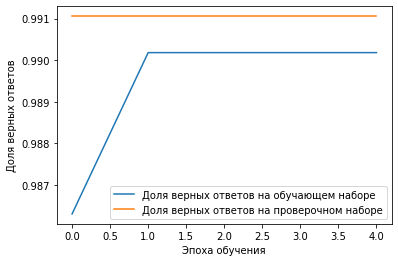

In [13]:
#Создаём полносвязную сеть
model = Sequential()
#Входной полносвязный слой
model.add(Dense(100, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.2)) 
#Второй полносвязный слой
model.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model.add(Dropout(0.3))
#Третий полносвязный слой
model.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model.add(Dropout(0.4))
#Выходной полносвязный слой
model.add(Dense(nClasses, activation='softmax'))#softmax, sigmoid
time_start = [time.time()]

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=5,
                    batch_size=64,
                    validation_data=(xVal, yVal),
                    verbose=2,
                    callbacks=callbacks)

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# **Модель для предсказания "Погибло детей"**

In [14]:
texts = df['Место'].values # Извлекаем данные всех текстов из столбца 'Текст Сообщения'
classes = list(df['Погибло детей'].values) # Извлекаем соответствующие им значения классов (лейблов) столбца 'Текст Сообщения'
maxWordsCount = 1000 # Зададим максимальное количество слов/индексов, учитываемое при обучении текстов

print(df['Погибло детей'].unique()) # Выводим все уникальные значения классов
nClasses = df['Погибло детей'].nunique() # Задаём количество классов, обращаясь к столбцу 'Категория' и оставляя уникальные значения
print('Количество классов =', nClasses) # Посмотрим на количество классов

[0 1]
Количество классов = 2


In [15]:
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='unknown', char_level=False)#False
tokenizer.fit_on_texts(texts) # Даём в обработку наши тексты, методу, который соберет словарь частотности
# Формируем матрицу индексов по принципу Bag of Words
xAll = tokenizer.texts_to_matrix(texts) # Каждое слово из текста нашло свой индекс в векторе длиной maxWordsCount и отметилось в нем единичкой 
print(xAll.shape)  # Посмотрим на форму текстов
print(xAll[0, :20])# И отдельно на фрагмент начала вектора

(35771, 1000)
[0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [16]:
#Преобразовываем категории в векторы
encoder = LabelEncoder() # Вызываем метод кодирования тестовых лейблов из библиотеки sklearn
encoder.fit(classes) # Подгружаем в него категории из нашей базы
classesEncoded = encoder.transform(classes) # Кодируем категории
print('Посмотрим кодированные категории', encoder.classes_) # Посмотрим кодированные категории
print('Количество',classesEncoded.shape)
print('Посмотрим как выглядят первые 17 категорий', classesEncoded[:17])

yAll = utils.to_categorical(classesEncoded, nClasses) # И выводим каждый лейбл в виде вектора длиной 17, с 1кой в позиции соответствующего класса и нулями
print('Форма лейблов', yAll.shape) # Посмотрим на форму лейблов категорий
print('Первая строка лейблов',yAll[0]) # И отдельно на первую строку

Посмотрим кодированные категории [0 1]
Количество (35771,)
Посмотрим как выглядят первые 17 категорий [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Форма лейблов (35771, 2)
Первая строка лейблов [1. 0.]


In [17]:
# разбиваем все данные на обучающую и тестовую выборки с помощью метода train_test_split из библиотеки sklearn
xTrain, xVal, yTrain, yVal = train_test_split(xAll, yAll, test_size=0.2, shuffle = True) # Берем 20% на тестовую выборку и перемешиваем данные
print(xTrain.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrain.shape) #и на форму соответсвующих им классов

(28616, 1000)
(28616, 2)


Epoch 1/5
448/448 - 5s - loss: 0.0148 - accuracy: 0.9981 - val_loss: 0.0072 - val_accuracy: 0.9994 - 5s/epoch - 12ms/step
Epoch 2/5
448/448 - 4s - loss: 0.0032 - accuracy: 0.9997 - val_loss: 0.0075 - val_accuracy: 0.9994 - 4s/epoch - 9ms/step
Epoch 3/5
448/448 - 3s - loss: 0.0032 - accuracy: 0.9997 - val_loss: 0.0091 - val_accuracy: 0.9994 - 3s/epoch - 7ms/step
Epoch 4/5
448/448 - 3s - loss: 0.0033 - accuracy: 0.9997 - val_loss: 0.0073 - val_accuracy: 0.9994 - 3s/epoch - 7ms/step
Epoch 5/5
448/448 - 4s - loss: 0.0023 - accuracy: 0.9997 - val_loss: 0.0109 - val_accuracy: 0.9994 - 4s/epoch - 9ms/step


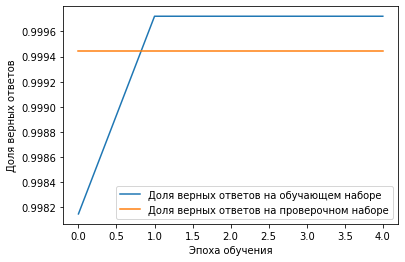

In [18]:
#Создаём полносвязную сеть
model02 = Sequential()
#Входной полносвязный слой
model02.add(Dense(100, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model02.add(Dropout(0.2)) 
#Второй полносвязный слой
model02.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model02.add(Dropout(0.3))
#Третий полносвязный слой
model02.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model02.add(Dropout(0.4))
#Выходной полносвязный слой
model02.add(Dense(nClasses, activation='softmax'))#softmax, sigmoid
time_start = [time.time()]

model02.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке
history = model02.fit(xTrain, 
                    yTrain, 
                    epochs=5,
                    batch_size=64,
                    validation_data=(xVal, yVal),
                    verbose=2,
                    callbacks=callbacks)

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# **Модель для предсказания "Ранено"**

In [19]:
texts = df['Место'].values # Извлекаем данные всех текстов из столбца 'Текст Сообщения'
classes = list(df['Ранено'].values) # Извлекаем соответствующие им значения классов (лейблов) столбца 'Текст Сообщения'
maxWordsCount = 1000 # Зададим максимальное количество слов/индексов, учитываемое при обучении текстов

print(df['Ранено'].unique()) # Выводим все уникальные значения классов
nClasses = df['Ранено'].nunique() # Задаём количество классов, обращаясь к столбцу 'Категория' и оставляя уникальные значения
print('Количество классов =', nClasses) # Посмотрим на количество классов

[0 2 1 5 4 3 6 8 7]
Количество классов = 9


In [20]:
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='unknown', char_level=False)#False
tokenizer.fit_on_texts(texts) # Даём в обработку наши тексты, методу, который соберет словарь частотности
# Формируем матрицу индексов по принципу Bag of Words
xAll = tokenizer.texts_to_matrix(texts) # Каждое слово из текста нашло свой индекс в векторе длиной maxWordsCount и отметилось в нем единичкой 
print(xAll.shape)  # Посмотрим на форму текстов
print(xAll[0, :20])# И отдельно на фрагмент начала вектора

(35771, 1000)
[0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [21]:
#Преобразовываем категории в векторы
encoder = LabelEncoder() # Вызываем метод кодирования тестовых лейблов из библиотеки sklearn
encoder.fit(classes) # Подгружаем в него категории из нашей базы
classesEncoded = encoder.transform(classes) # Кодируем категории
print('Посмотрим кодированные категории', encoder.classes_) # Посмотрим кодированные категории
print('Количество',classesEncoded.shape)
print('Посмотрим как выглядят первые 17 категорий', classesEncoded[:17])

yAll = utils.to_categorical(classesEncoded, nClasses) # И выводим каждый лейбл в виде вектора длиной 17, с 1кой в позиции соответствующего класса и нулями
print('Форма лейблов', yAll.shape) # Посмотрим на форму лейблов категорий
print('Первая строка лейблов',yAll[0]) # И отдельно на первую строку

Посмотрим кодированные категории [0 1 2 3 4 5 6 7 8]
Количество (35771,)
Посмотрим как выглядят первые 17 категорий [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Форма лейблов (35771, 9)
Первая строка лейблов [1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [22]:
# разбиваем все данные на обучающую и тестовую выборки с помощью метода train_test_split из библиотеки sklearn
xTrain, xVal, yTrain, yVal = train_test_split(xAll, yAll, test_size=0.2, shuffle = True) # Берем 20% на тестовую выборку и перемешиваем данные
print(xTrain.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrain.shape) #и на форму соответсвующих им классов

(28616, 1000)
(28616, 9)


Epoch 1/10
448/448 - 4s - loss: 0.5308 - accuracy: 0.8736 - val_loss: 0.4841 - val_accuracy: 0.8683 - 4s/epoch - 10ms/step
Epoch 2/10
448/448 - 3s - loss: 0.4777 - accuracy: 0.8742 - val_loss: 0.4824 - val_accuracy: 0.8682 - 3s/epoch - 6ms/step
Epoch 3/10
448/448 - 2s - loss: 0.4686 - accuracy: 0.8740 - val_loss: 0.4838 - val_accuracy: 0.8683 - 2s/epoch - 4ms/step
Epoch 4/10
448/448 - 2s - loss: 0.4629 - accuracy: 0.8736 - val_loss: 0.4856 - val_accuracy: 0.8683 - 2s/epoch - 5ms/step
Epoch 5/10
448/448 - 2s - loss: 0.4604 - accuracy: 0.8736 - val_loss: 0.4904 - val_accuracy: 0.8683 - 2s/epoch - 4ms/step
Epoch 6/10
448/448 - 2s - loss: 0.4545 - accuracy: 0.8735 - val_loss: 0.4893 - val_accuracy: 0.8679 - 2s/epoch - 4ms/step
Epoch 7/10
448/448 - 2s - loss: 0.4514 - accuracy: 0.8734 - val_loss: 0.4907 - val_accuracy: 0.8683 - 2s/epoch - 4ms/step
Epoch 8/10
448/448 - 2s - loss: 0.4452 - accuracy: 0.8740 - val_loss: 0.5022 - val_accuracy: 0.8682 - 2s/epoch - 5ms/step
Epoch 9/10
448/448 - 2s

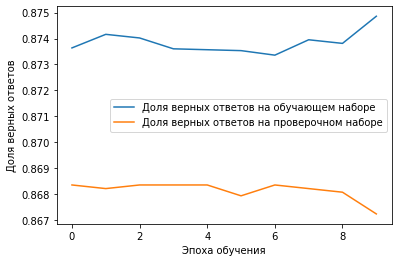

In [23]:
#Создаём полносвязную сеть
model03 = Sequential()
#Входной полносвязный слой
model03.add(Dense(100, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model03.add(Dropout(0.2)) 
#Второй полносвязный слой
model03.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model03.add(Dropout(0.3))
#Третий полносвязный слой
model03.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model03.add(Dropout(0.4))
#Выходной полносвязный слой
model03.add(Dense(nClasses, activation='softmax'))#softmax, sigmoid
time_start = [time.time()]

model03.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке
history = model03.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=64,
                    validation_data=(xVal, yVal),
                    verbose=2,
                    callbacks=callbacks)

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# **Модель для предсказания "Ранено детей"**

In [24]:
texts = df['Место'].values # Извлекаем данные всех текстов из столбца 'Текст Сообщения'
classes = list(df['Ранено детей'].values) # Извлекаем соответствующие им значения классов (лейблов) столбца 'Текст Сообщения'
maxWordsCount = 1000 # Зададим максимальное количество слов/индексов, учитываемое при обучении текстов

print(df['Ранено детей'].unique()) # Выводим все уникальные значения классов
nClasses = df['Ранено детей'].nunique() # Задаём количество классов, обращаясь к столбцу 'Категория' и оставляя уникальные значения
print('Количество классов =', nClasses) # Посмотрим на количество классов

[0 1 2 3 4]
Количество классов = 5


In [25]:
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='unknown', char_level=False)#False
tokenizer.fit_on_texts(texts) # Даём в обработку наши тексты, методу, который соберет словарь частотности
# Формируем матрицу индексов по принципу Bag of Words
xAll = tokenizer.texts_to_matrix(texts) # Каждое слово из текста нашло свой индекс в векторе длиной maxWordsCount и отметилось в нем единичкой 
print(xAll.shape)  # Посмотрим на форму текстов
print(xAll[0, :20])# И отдельно на фрагмент начала вектора

(35771, 1000)
[0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [26]:
#Преобразовываем категории в векторы
encoder = LabelEncoder() # Вызываем метод кодирования тестовых лейблов из библиотеки sklearn
encoder.fit(classes) # Подгружаем в него категории из нашей базы
classesEncoded = encoder.transform(classes) # Кодируем категории
print('Посмотрим кодированные категории', encoder.classes_) # Посмотрим кодированные категории
print('Количество',classesEncoded.shape)
print('Посмотрим как выглядят первые 17 категорий', classesEncoded[:17])

yAll = utils.to_categorical(classesEncoded, nClasses) # И выводим каждый лейбл в виде вектора длиной 17, с 1кой в позиции соответствующего класса и нулями
print('Форма лейблов', yAll.shape) # Посмотрим на форму лейблов категорий
print('Первая строка лейблов',yAll[0]) # И отдельно на первую строку

Посмотрим кодированные категории [0 1 2 3 4]
Количество (35771,)
Посмотрим как выглядят первые 17 категорий [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Форма лейблов (35771, 5)
Первая строка лейблов [1. 0. 0. 0. 0.]


In [27]:
# разбиваем все данные на обучающую и тестовую выборки с помощью метода train_test_split из библиотеки sklearn
xTrain, xVal, yTrain, yVal = train_test_split(xAll, yAll, test_size=0.2, shuffle = True) # Берем 20% на тестовую выборку и перемешиваем данные
print(xTrain.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrain.shape) #и на форму соответсвующих им классов

(28616, 1000)
(28616, 5)


Epoch 1/10
448/448 - 3s - loss: 0.1672 - accuracy: 0.9735 - val_loss: 0.1221 - val_accuracy: 0.9764 - 3s/epoch - 7ms/step
Epoch 2/10
448/448 - 2s - loss: 0.1190 - accuracy: 0.9788 - val_loss: 0.1207 - val_accuracy: 0.9764 - 2s/epoch - 4ms/step
Epoch 3/10
448/448 - 2s - loss: 0.1162 - accuracy: 0.9788 - val_loss: 0.1252 - val_accuracy: 0.9764 - 2s/epoch - 5ms/step
Epoch 4/10
448/448 - 2s - loss: 0.1139 - accuracy: 0.9788 - val_loss: 0.1218 - val_accuracy: 0.9764 - 2s/epoch - 5ms/step
Epoch 5/10
448/448 - 2s - loss: 0.1108 - accuracy: 0.9788 - val_loss: 0.1219 - val_accuracy: 0.9764 - 2s/epoch - 5ms/step
Epoch 6/10
448/448 - 3s - loss: 0.1106 - accuracy: 0.9788 - val_loss: 0.1265 - val_accuracy: 0.9764 - 3s/epoch - 6ms/step
Epoch 7/10
448/448 - 3s - loss: 0.1070 - accuracy: 0.9788 - val_loss: 0.1265 - val_accuracy: 0.9764 - 3s/epoch - 7ms/step
Epoch 8/10
448/448 - 3s - loss: 0.1053 - accuracy: 0.9788 - val_loss: 0.1293 - val_accuracy: 0.9764 - 3s/epoch - 6ms/step
Epoch 9/10
448/448 - 3s 

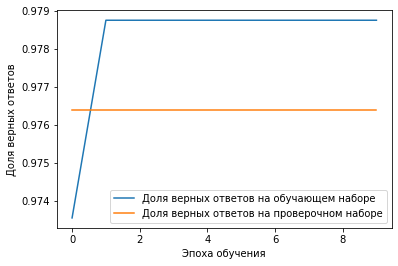

In [28]:
#Создаём полносвязную сеть
model04 = Sequential()
#Входной полносвязный слой
model04.add(Dense(100, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model04.add(Dropout(0.2)) 
#Второй полносвязный слой
model04.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model04.add(Dropout(0.3))
#Третий полносвязный слой
model04.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model04.add(Dropout(0.4))
#Выходной полносвязный слой
model04.add(Dense(nClasses, activation='softmax'))#softmax, sigmoid
time_start = [time.time()]

model04.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке
history = model04.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=64,
                    validation_data=(xVal, yVal),
                    verbose=2,
                    callbacks=callbacks)

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# **Предиктим тестовый набор данных**

In [29]:
# Загружаем датасет
df_test = pd.read_csv('/content/drive/MyDrive/Предобученные сети/Дагенстан_ДТП/test_dataset_test.csv')

In [30]:
df_test.drop(df_test.columns[[4,5,6,7,8]], axis=1, inplace=True) # Убираем лишнии столцы 

In [31]:
df_test['Вид ДТП'].fillna(value='Не известно', inplace=True) # Заменим пропуски на 'Иной вид ДТП'

In [32]:
# Объдиняем места, вида ДТП и временые интервалы
df_test["Место"] = df_test["Дата"].astype(str) +  " " + df_test["Время"].astype(str) + " " + df_test["Место"].astype(str) + " " + df_test["Вид ДТП"].astype(str) 

In [33]:
df_test

,id,Дата,Время,Место,Вид ДТП
0,490078911,31.01.2018,19:15:00,"31.01.2018 19:15:00 Новгородская область, Вели...",Столкновение
1,490055448,19.06.2019,10:15:00,"19.06.2019 10:15:00 Новгородская область, Вели...",Столкновение
2,490054440,28.06.2019,03:00:00,"28.06.2019 03:00:00 Новгородская область, Вели...",Наезд на препятствие
3,490037847,01.02.2019,13:15:00,"01.02.2019 13:15:00 Новгородская область, Вели...",Наезд на препятствие
4,490037049,08.02.2019,10:35:00,"08.02.2019 10:35:00 Новгородская область, Окул...",Наезд на препятствие
...,...,...,...,...,...
6783,490014641,11.07.2020,23:15:00,"11.07.2020 23:15:00 Новгородская область, Боро...",Не известно
6784,490033115,12.01.2020,15:20:00,"12.01.2020 15:20:00 Новгородская область, Окул...",Не известно
6785,490008221,04.09.2020,20:05:00,"04.09.2020 20:05:00 Новгородская область, Новг...",Не известно
6786,490119585,11.11.2018,16:25:00,"11.11.2018 16:25:00 Новгородская область, Окул...",Столкновение


**Определяем число "Погибших"**

In [34]:
test_mess = np.array(df_test['Место']) # Переводим сообщения в массив
x = tokenizer.texts_to_matrix(test_mess) # Токенизируем массив

prediction = model.predict(x)

for i in range(len(x)): # Циклом проходимся по токенизированному массиву
  df_test.loc[i,'Погибло'] = np.argmax(prediction[i]) # Присваеваем категорию каждому обращению 
df_test = df_test.astype({'Погибло':'Int64'}) # Переводим цифры в целочисленный формат
df_test # Смотрим что получилось

,id,Дата,Время,Место,Вид ДТП,Погибло
0,490078911,31.01.2018,19:15:00,"31.01.2018 19:15:00 Новгородская область, Вели...",Столкновение,0
1,490055448,19.06.2019,10:15:00,"19.06.2019 10:15:00 Новгородская область, Вели...",Столкновение,0
2,490054440,28.06.2019,03:00:00,"28.06.2019 03:00:00 Новгородская область, Вели...",Наезд на препятствие,0
3,490037847,01.02.2019,13:15:00,"01.02.2019 13:15:00 Новгородская область, Вели...",Наезд на препятствие,0
4,490037049,08.02.2019,10:35:00,"08.02.2019 10:35:00 Новгородская область, Окул...",Наезд на препятствие,0
...,...,...,...,...,...,...
6783,490014641,11.07.2020,23:15:00,"11.07.2020 23:15:00 Новгородская область, Боро...",Не известно,0
6784,490033115,12.01.2020,15:20:00,"12.01.2020 15:20:00 Новгородская область, Окул...",Не известно,0
6785,490008221,04.09.2020,20:05:00,"04.09.2020 20:05:00 Новгородская область, Новг...",Не известно,0
6786,490119585,11.11.2018,16:25:00,"11.11.2018 16:25:00 Новгородская область, Окул...",Столкновение,0


**Определяем число "Погибших детей"**

In [35]:
test_mess = np.array(df_test['Место']) # Переводим сообщения в массив
x = tokenizer.texts_to_matrix(test_mess) # Токенизируем массив

prediction = model02.predict(x)

for i in range(len(x)): # Циклом проходимся по токенизированному массиву
  df_test.loc[i,'Погибло детей'] = np.argmax(prediction[i]) # Присваеваем категорию каждому обращению 
df_test = df_test.astype({'Погибло детей':'Int64'}) # Переводим цифры в целочисленный формат
df_test # Смотрим что получилось

,id,Дата,Время,Место,Вид ДТП,Погибло,Погибло детей
0,490078911,31.01.2018,19:15:00,"31.01.2018 19:15:00 Новгородская область, Вели...",Столкновение,0,0
1,490055448,19.06.2019,10:15:00,"19.06.2019 10:15:00 Новгородская область, Вели...",Столкновение,0,0
2,490054440,28.06.2019,03:00:00,"28.06.2019 03:00:00 Новгородская область, Вели...",Наезд на препятствие,0,0
3,490037847,01.02.2019,13:15:00,"01.02.2019 13:15:00 Новгородская область, Вели...",Наезд на препятствие,0,0
4,490037049,08.02.2019,10:35:00,"08.02.2019 10:35:00 Новгородская область, Окул...",Наезд на препятствие,0,0
...,...,...,...,...,...,...,...
6783,490014641,11.07.2020,23:15:00,"11.07.2020 23:15:00 Новгородская область, Боро...",Не известно,0,0
6784,490033115,12.01.2020,15:20:00,"12.01.2020 15:20:00 Новгородская область, Окул...",Не известно,0,0
6785,490008221,04.09.2020,20:05:00,"04.09.2020 20:05:00 Новгородская область, Новг...",Не известно,0,0
6786,490119585,11.11.2018,16:25:00,"11.11.2018 16:25:00 Новгородская область, Окул...",Столкновение,0,0


**Определяем число "Раненых"**

In [36]:
test_mess = np.array(df_test['Место']) # Переводим сообщения в массив
x = tokenizer.texts_to_matrix(test_mess) # Токенизируем массив

prediction = model03.predict(x)

for i in range(len(x)): # Циклом проходимся по токенизированному массиву
  df_test.loc[i,'Ранено'] = np.argmax(prediction[i]) # Присваеваем категорию каждому обращению 
df_test = df_test.astype({'Ранено':'Int64'}) # Переводим цифры в целочисленный формат
df_test # Смотрим что получилось

,id,Дата,Время,Место,Вид ДТП,Погибло,Погибло детей,Ранено
0,490078911,31.01.2018,19:15:00,"31.01.2018 19:15:00 Новгородская область, Вели...",Столкновение,0,0,0
1,490055448,19.06.2019,10:15:00,"19.06.2019 10:15:00 Новгородская область, Вели...",Столкновение,0,0,0
2,490054440,28.06.2019,03:00:00,"28.06.2019 03:00:00 Новгородская область, Вели...",Наезд на препятствие,0,0,0
3,490037847,01.02.2019,13:15:00,"01.02.2019 13:15:00 Новгородская область, Вели...",Наезд на препятствие,0,0,0
4,490037049,08.02.2019,10:35:00,"08.02.2019 10:35:00 Новгородская область, Окул...",Наезд на препятствие,0,0,0
...,...,...,...,...,...,...,...,...
6783,490014641,11.07.2020,23:15:00,"11.07.2020 23:15:00 Новгородская область, Боро...",Не известно,0,0,0
6784,490033115,12.01.2020,15:20:00,"12.01.2020 15:20:00 Новгородская область, Окул...",Не известно,0,0,0
6785,490008221,04.09.2020,20:05:00,"04.09.2020 20:05:00 Новгородская область, Новг...",Не известно,0,0,0
6786,490119585,11.11.2018,16:25:00,"11.11.2018 16:25:00 Новгородская область, Окул...",Столкновение,0,0,0


**Определяем число "Раненых детей"**

In [37]:
test_mess = np.array(df_test['Место']) # Переводим сообщения в массив
x = tokenizer.texts_to_matrix(test_mess) # Токенизируем массив

prediction = model04.predict(x)

for i in range(len(x)): # Циклом проходимся по токенизированному массиву
  df_test.loc[i,'Ранено детей'] = np.argmax(prediction[i]) # Присваеваем категорию каждому обращению 
df_test = df_test.astype({'Ранено детей':'Int64'}) # Переводим цифры в целочисленный формат
df_test # Смотрим что получилось

,id,Дата,Время,Место,Вид ДТП,Погибло,Погибло детей,Ранено,Ранено детей
0,490078911,31.01.2018,19:15:00,"31.01.2018 19:15:00 Новгородская область, Вели...",Столкновение,0,0,0,0
1,490055448,19.06.2019,10:15:00,"19.06.2019 10:15:00 Новгородская область, Вели...",Столкновение,0,0,0,0
2,490054440,28.06.2019,03:00:00,"28.06.2019 03:00:00 Новгородская область, Вели...",Наезд на препятствие,0,0,0,0
3,490037847,01.02.2019,13:15:00,"01.02.2019 13:15:00 Новгородская область, Вели...",Наезд на препятствие,0,0,0,0
4,490037049,08.02.2019,10:35:00,"08.02.2019 10:35:00 Новгородская область, Окул...",Наезд на препятствие,0,0,0,0
...,...,...,...,...,...,...,...,...,...
6783,490014641,11.07.2020,23:15:00,"11.07.2020 23:15:00 Новгородская область, Боро...",Не известно,0,0,0,0
6784,490033115,12.01.2020,15:20:00,"12.01.2020 15:20:00 Новгородская область, Окул...",Не известно,0,0,0,0
6785,490008221,04.09.2020,20:05:00,"04.09.2020 20:05:00 Новгородская область, Новг...",Не известно,0,0,0,0
6786,490119585,11.11.2018,16:25:00,"11.11.2018 16:25:00 Новгородская область, Окул...",Столкновение,0,0,0,0


**Приводим тестовый набор к формату для сдачи жури**

In [38]:
# Удаляем колонку с текстом 
df_test.drop(df_test.columns[[1,2,3,4]], axis=1, inplace=True)

In [39]:
# Сохраняем файл в формете .csv без индексов
df_test.to_csv('/content/drive/MyDrive/Предобученные сети/Дагенстан_ДТП/df_test_DTP_7_all_train.csv', index=False)

 **Score = 0.419469**
